In [51]:
import datetime
import yfinance as yf
import pandas as pd


ticker='NVDA'  
crossover_points = {} #dictionary to store the dataframes for each ticke


start_date='2020-01-01'
end_date=datetime.datetime.today().strftime('%Y-%m-%d')
# Base Moving Average Crossover Inidicator

crossover_points = pd.DataFrame(columns=['Action', 'Price', 'Date'])
df=yf.download(ticker,start=start_date,end=end_date)
df['SMA_50']=df['Close'].rolling(window=50).mean()
df['SMA_200']=df['Close'].rolling(window=200).mean()
for i in range(1, len(df['Adj Close']) - 2):
    
    if df['SMA_50'][i-1] > df['SMA_200'][i] and df['SMA_50'][i] < df['SMA_200'][i+2]:
        new_row = pd.DataFrame({'Action': ['SELL'], 'Price': [round(df['Adj Close'][i],2)], 'Date': [df.reset_index()['Date'][i].date()]})
        crossover_points = pd.concat([crossover_points, new_row], ignore_index=True)


    if df['SMA_50'][i-1] < df['SMA_200'][i] and df['SMA_50'][i] > df['SMA_200'][i+2]:
        new_row = pd.DataFrame({'Action': ['BUY'], 'Price': [round(df['Adj Close'][i],2)], 'Date': [df.reset_index()['Date'][i].date()]})
        crossover_points = pd.concat([crossover_points, new_row], ignore_index=True)

combined=crossover_points
combined.reset_index(drop=True, inplace=True)

combined.columns=['Action','Price','Date']
combined = combined.sort_values(['Date'])

combined['Date'] = pd.to_datetime(combined['Date'])
combined = combined.sort_values('Date', ascending=False)

all_trade_points=[]

trade_points=combined
if not trade_points.empty:
    trade_points['Time between Trades'] = -trade_points['Date'].diff()
    trade_points.loc[trade_points['Time between Trades'] < pd.Timedelta(days=7), 'Time between Trades'] = 'No Trade'
    trade_points['Override'] = 'Trade'
    # Ensure the condition is applied correctly

    if trade_points['Action'].iloc[-1] == 'SELL':
        trade_points['Override'].iloc[-1] = 'No Trade'


    for i in range(len(trade_points)-1):
    #Duplicate order rules

        if trade_points['Action'].iloc[i] == 'SELL' and trade_points['Action'].iloc[i+1] == 'SELL':
            trade_points['Override'].iloc[i+1] = 'No Trade'
        
        if trade_points['Action'].iloc[i] == 'BUY' and trade_points['Action'].iloc[i+1] == 'BUY':
            trade_points['Override'].iloc[i+1] = 'No Trade'
    all_trade_points.append(trade_points)

updated_trade_points = pd.concat(all_trade_points)
updated_trade_points=updated_trade_points.sort_values('Date', ascending=False)
updated_trade_points.reset_index()



[*********************100%%**********************]  1 of 1 completed


,index,Action,Price,Date,Time between Trades,Override
0,1,BUY,19.25,2023-01-24,NaT,Trade
1,0,SELL,21.45,2022-04-20,279 days 00:00:00,No Trade


In [52]:
import itertools
import warnings
from statsmodels.tsa.arima.model import ARIMA

warnings.filterwarnings("ignore")

# Define the p, d, q parameters to take any value between 0 and 2
p = d = q = range(0, 3)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

# Find the best ARIMA model parameters
best_aic = float("inf")
best_pdq = None
best_model = None

for param in pdq:
    try:
        model = ARIMA(time_series_data, order=param)
        model_fit = model.fit()
        if model_fit.aic < best_aic:
            best_aic = model_fit.aic
            best_pdq = param
            best_model = model_fit
    except:
        continue

print(f"Best ARIMA parameters: {best_pdq}")

Best ARIMA parameters: (2, 1, 1)


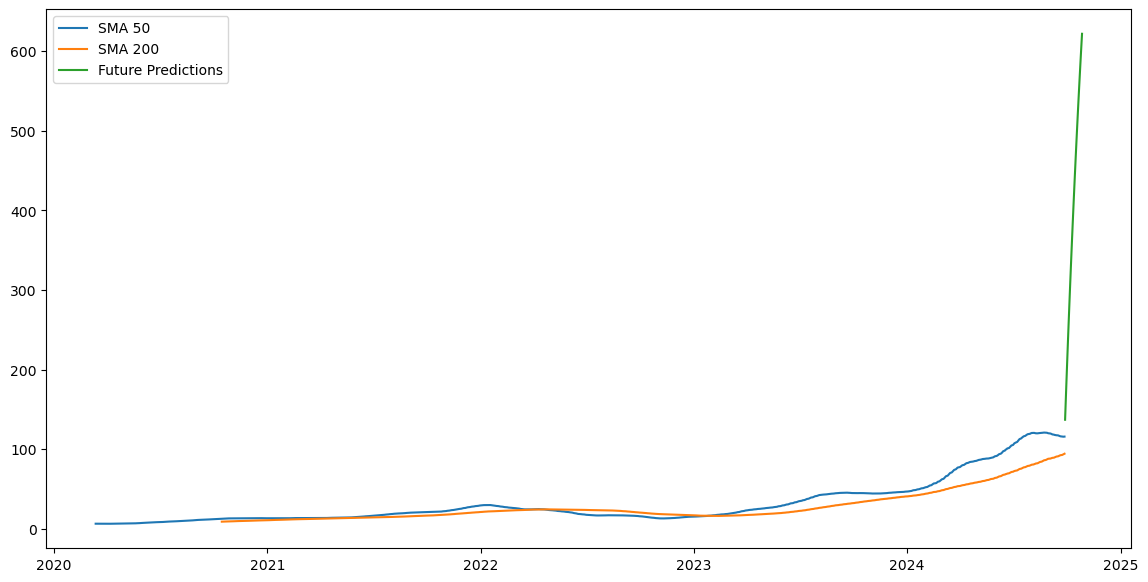

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Assuming df is your DataFrame with 'SMA_50' and 'SMA_200'
# We will use the difference between SMA_50 and SMA_200 as the time series data
df['SMA_diff'] = df['SMA_50'] - df['SMA_200']

# Prepare the data
time_series_data = df['SMA_diff'].dropna()

# Fit the ARIMA model
model = ARIMA(time_series_data, order=(best_pdq[0], best_pdq[1], best_pdq[2]))  # (p, d, q) order
model_fit = model.fit()

# Make future predictions
future_steps = 30
forecast = model_fit.forecast(steps=future_steps)

# Create a new index for the future predictions
last_index = df.index[-1]
future_index = pd.date_range(start=last_index, periods=future_steps + 1, closed='right')

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(df['SMA_50'], label='SMA 50')
plt.plot(df['SMA_200'], label='SMA 200')
plt.plot(future_index, df['SMA_50'].iloc[-1] + forecast.cumsum(), label='Future Predictions')
plt.legend()
plt.show()

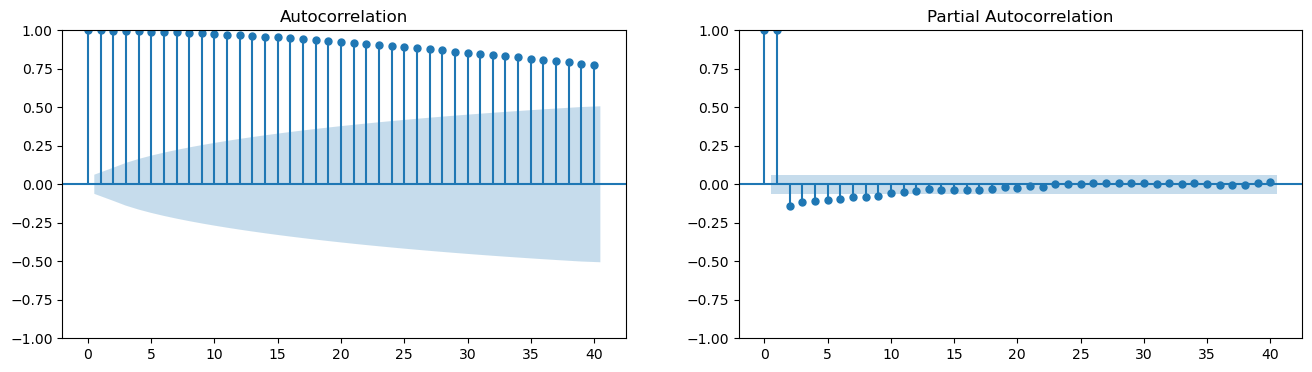

In [54]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
plot_acf(time_series_data, lags=40, ax=axes[0])
plot_pacf(time_series_data, lags=40, ax=axes[1])
plt.show()